In [ ]:
import numpy as np
class CustomDecisionTree:
    def __init__(self, max_depth=None):
        """
        Initializes the decision tree with the specified maximum depth.
        Parameters:
            max_depth (int, optional): The maximum depth of the tree. If None, the tree is expanded until all
            leaves are pure or contain fewer than the minimum samples required to split.
        """
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        """
        Trains the decision tree model using the provided training data.
        Parameters:
            X (array-like): Feature matrix (n_samples, n_features) for training the model.
            y (array-like): Target labels (n_samples,) for training the model.
        """
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        """
        Recursively builds the decision tree by splitting the data based on the best feature and threshold
        .
        Parameters:
            X (array-like): Feature matrix (n_samples, n_features) for splitting.
            y (array-like): Target labels (n_samples,) for splitting.
            depth (int, optional): Current depth of the tree during recursion.
        Returns:
            dict: A dictionary representing the structure of the tree, containing the best feature index,
            threshold, and recursive tree nodes.
        """
        num_samples, num_features = X.shape
        unique_classes = np.unique(y)

        # Stopping conditions: pure node or reached max depth
        if len(unique_classes) == 1:
            return {'class': unique_classes[0]}
        if num_samples == 0 or (self.max_depth and depth >= self.max_depth):
            return {'class': np.bincount(y).argmax()}

        # Find the best split based on Information Gain (using Entropy)
        best_info_gain = -float('inf')
        best_split = None

        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask

                left_y = y[left_mask]
                right_y = y[right_mask]

                info_gain = self._information_gain(y, left_y, right_y)

                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_split = {
                        'feature_idx': feature_idx,
                        'threshold': threshold,
                        'left_y': left_y,
                        'right_y': right_y,
                    }

        if best_split is None:
            return {'class': np.bincount(y).argmax()}

        # Recursively build the left and right subtrees
        left_tree = self._build_tree(X[best_split['left_y']], best_split['left_y'], depth + 1)
        right_tree = self._build_tree(X[best_split['right_y']], best_split['right_y'], depth + 1)

        return {'feature_idx': best_split['feature_idx'], 'threshold': best_split['threshold'],
                'left_tree': left_tree, 'right_tree': right_tree}

    def _information_gain(self, parent, left, right):
        """
        Computes the Information Gain between the parent node and the left/right child nodes.
        Parameters:
            parent (array-like): The labels of the parent node.
            left (array-like): The labels of the left child node.
            right (array-like): The labels of the right child node.
        Returns:
            float: The Information Gain of the split.
        """
        parent_entropy = self._entropy(parent)
        left_entropy = self._entropy(left)
        right_entropy = self._entropy(right)

        # Information Gain = Entropy(parent) - (weighted average of left and right entropies)
        weighted_avg_entropy = (len(left) / len(parent)) * left_entropy + \
                               (len(right) / len(parent)) * right_entropy
        return parent_entropy - weighted_avg_entropy

    def _entropy(self, y):
        """
        Computes the entropy of a set of labels.
        Parameters:
            y (array-like): The labels for which entropy is calculated.
        Returns:
            float: The entropy of the labels.
        """
        # Calculate the probability of each class
        class_probs = np.bincount(y) / len(y)
        # Compute the entropy using the formula: -sum(p * log2(p))
        return -np.sum(class_probs * np.log2(class_probs + 1e-9)) # Added small epsilon to avoid log(0)

    def predict(self, X):
        """
        Predicts the target labels for the given test data based on the trained decision tree.
        Parameters:
            X (array-like): Feature matrix (n_samples, n_features) for prediction.
        Returns:
            list: A list of predicted target labels (n_samples,).
        """
        return [self._predict_single(x, self.tree) for x in X]

    def _predict_single(self, x, tree):
        """
        Recursively predicts the target label for a single sample by traversing the tree.
        Parameters:
            x (array-like): A single feature vector for prediction.
            tree (dict): The current subtree or node to evaluate.
        Returns:
            int: The predicted class label for the sample.
        """
        if 'class' in tree:
            return tree['class']
        feature_val = x[tree['feature_idx']]
        if feature_val <= tree['threshold']:
            return self._predict_single(x, tree['left_tree'])
        else:
            return self._predict_single(x, tree['right_tree'])

In [ ]:
# Necessary Imports
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# Load the Iris dataset
data = load_iris()
X = data.data
y = data.target
# Split into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train the custom decision tree
custom_tree = CustomDecisionTree(max_depth=3)
custom_tree.fit(X_train, y_train)
# Predict on the test set
y_pred_custom = custom_tree.predict(X_test)
# Calculate accuracy
accuracy_custom = accuracy_score(y_test, y_pred_custom)
print(f"Custom Decision Tree Accuracy: {accuracy_custom:.4f}")

Custom Decision Tree Accuracy: 0.8000


In [ ]:
# Train the Scikit-learn decision tree
sklearn_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
sklearn_tree.fit(X_train, y_train)
# Predict on the test set
y_pred_sklearn = sklearn_tree.predict(X_test)
# Calculate accuracy
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
print(f"Scikit-learn Decision Tree Accuracy: {accuracy_sklearn:.4f}")

Scikit-learn Decision Tree Accuracy: 1.0000


In [ ]:
print(f"Accuracy Comparison:")
print(f"Custom Decision Tree: {accuracy_custom:.4f}")
print(f"Scikit-learn Decision Tree: {accuracy_sklearn:.4f}")

Accuracy Comparison:
Custom Decision Tree: 0.8000
Scikit-learn Decision Tree: 1.0000


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

data = load_iris()
X = data.data
y = data.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_classifier = RandomForestClassifier(random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_rf_classifier = grid_search.best_estimator_
y_pred = best_rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", test_accuracy)

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9583333333333334
Test set accuracy: 1.0


Dataset shape: (178, 13)
Number of features: 13
Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Target names: ['class_0' 'class_1' 'class_2']
Class distribution: [59 71 48]

Training set size: (124, 13)
Test set size: (54, 13)

1. CLASSIFICATION MODELS IMPLEMENTATION

Decision Tree Classifier Results:
F1 Score (weighted): 0.9632

Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      0.94      0.97        18
     class_1       0.91      1.00      0.95        21
     class_2       1.00      0.93      0.97        15

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54


Random Forest Classifier Results:
F1 Score (weighted): 1.0000

Classification Report:


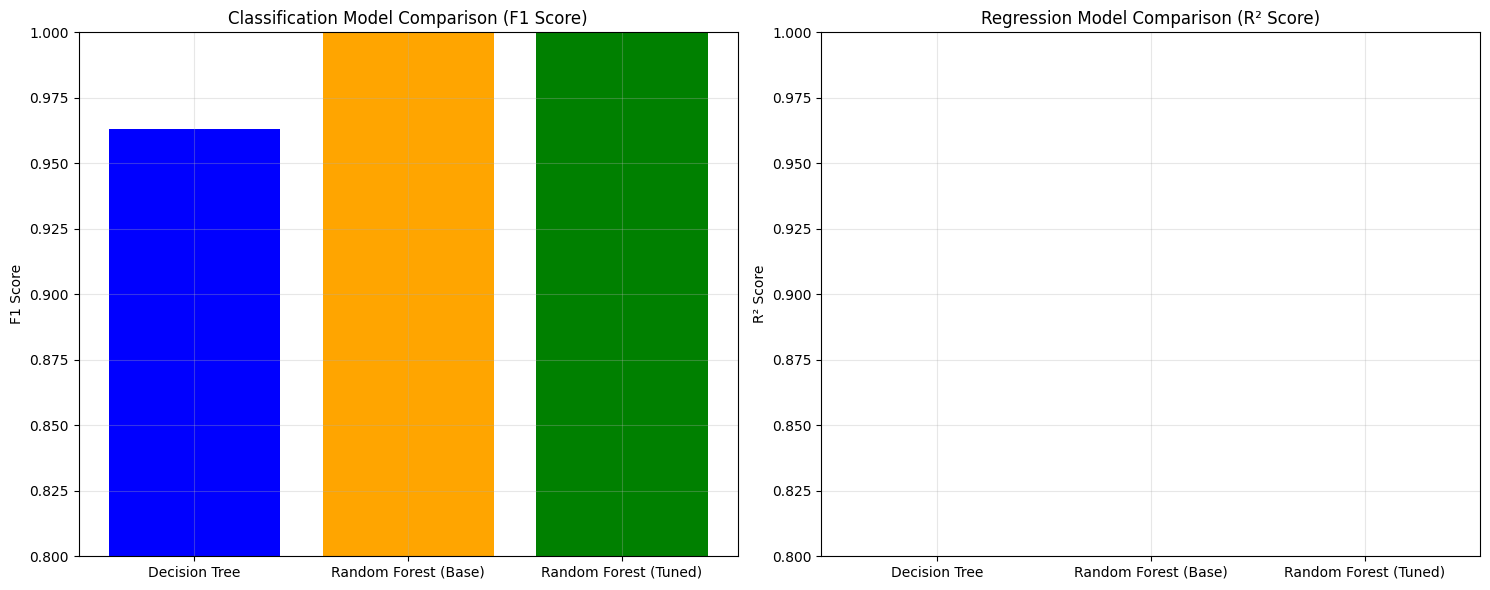

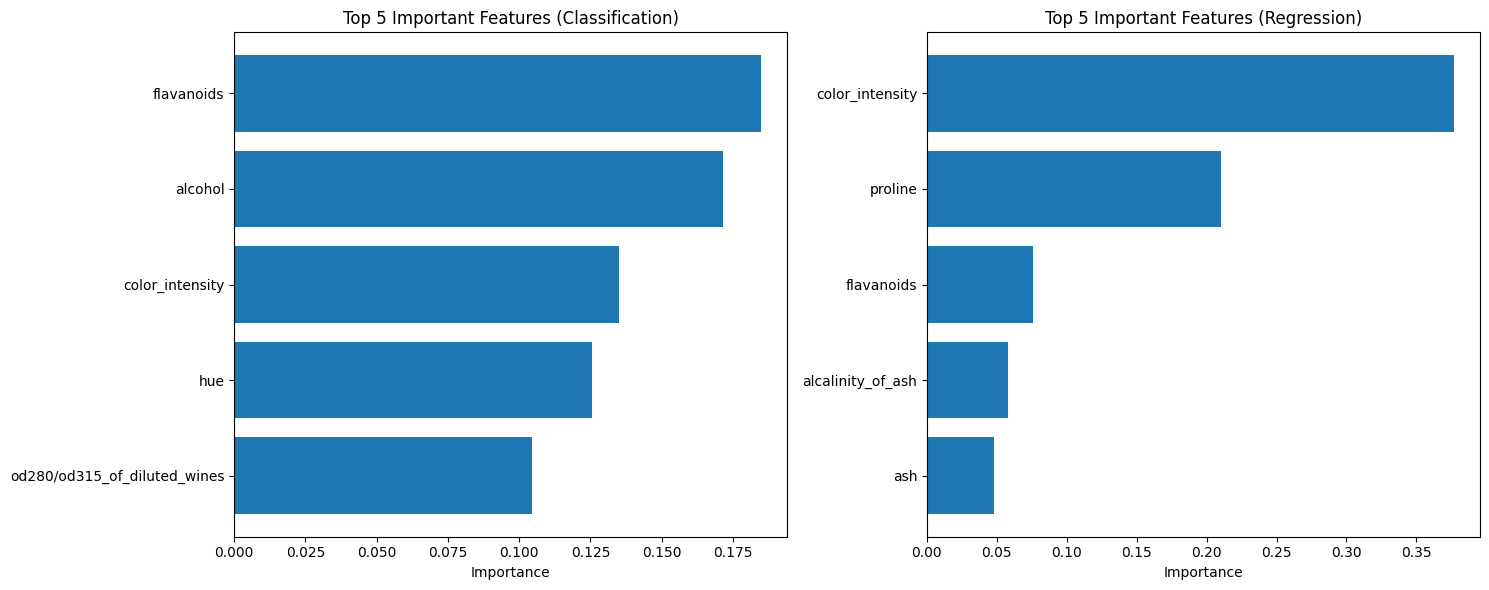

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, mean_squared_error, r2_score, classification_report
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Load the Wine dataset
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names
target_names = wine.target_names

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Feature names: {feature_names}")
print(f"Target names: {target_names}")
print(f"Class distribution: {np.bincount(y)}")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set size: {X_train_scaled.shape}")
print(f"Test set size: {X_test_scaled.shape}")

# ============================================
# 1. CLASSIFICATION MODELS
# ============================================

print("\n" + "="*50)
print("1. CLASSIFICATION MODELS IMPLEMENTATION")
print("="*50)

# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train_scaled, y_train)
y_pred_dt = dt_clf.predict(X_test_scaled)
dt_f1 = f1_score(y_test, y_pred_dt, average='weighted')

print(f"\nDecision Tree Classifier Results:")
print(f"F1 Score (weighted): {dt_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train_scaled, y_train)
y_pred_rf = rf_clf.predict(X_test_scaled)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\nRandom Forest Classifier Results:")
print(f"F1 Score (weighted): {rf_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))

# Compare models
print("\n" + "="*50)
print("MODEL COMPARISON (Classification)")
print("="*50)
print(f"Decision Tree F1 Score: {dt_f1:.4f}")
print(f"Random Forest F1 Score: {rf_f1:.4f}")
print(f"Improvement: {(rf_f1 - dt_f1):.4f} ({(rf_f1 - dt_f1)/dt_f1*100:.2f}%)")

# ============================================
# 2. HYPERPARAMETER TUNING - CLASSIFICATION
# ============================================

print("\n" + "="*50)
print("2. HYPERPARAMETER TUNING - CLASSIFICATION (GridSearchCV)")
print("="*50)

# Define the parameter grid for Random Forest Classifier
param_grid_clf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for best split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used
}

# Create GridSearchCV object
grid_search_clf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_clf,
    cv=5,  # 5-fold cross-validation
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print("Starting GridSearchCV for Random Forest Classifier...")
grid_search_clf.fit(X_train_scaled, y_train)

print("\nBest Parameters from GridSearchCV:")
for param, value in grid_search_clf.best_params_.items():
    print(f"{param}: {value}")

print(f"\nBest Cross-validation F1 Score: {grid_search_clf.best_score_:.4f}")

# Evaluate the best model
best_rf_clf = grid_search_clf.best_estimator_
y_pred_best = best_rf_clf.predict(X_test_scaled)
best_f1 = f1_score(y_test, y_pred_best, average='weighted')

print(f"\nBest Model Test F1 Score: {best_f1:.4f}")

# Feature importance from the best model
print("\nTop 5 Most Important Features:")
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importances.head())

# ============================================
# 3. REGRESSION MODELS (using alcohol content as target)
# ============================================

print("\n" + "="*50)
print("3. REGRESSION MODELS IMPLEMENTATION")
print("="*50)

# For regression, let's use 'alcohol' as target and other features as predictors
# First, create regression dataset
alcohol_idx = list(feature_names).index('alcohol')
X_reg = np.delete(X, alcohol_idx, axis=1)  # Remove alcohol from features
y_reg = X[:, alcohol_idx]  # Use alcohol as target
reg_feature_names = [name for name in feature_names if name != 'alcohol']

print(f"Regression Dataset shape: {X_reg.shape}")
print(f"Target variable: 'alcohol' content")
print(f"Predictor features: {reg_feature_names}")

# Split regression data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

# Scale features
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train_reg_scaled, y_train_reg)
y_pred_dt_reg = dt_reg.predict(X_test_reg_scaled)
dt_mse = mean_squared_error(y_test_reg, y_pred_dt_reg)
dt_r2 = r2_score(y_test_reg, y_pred_dt_reg)

print(f"\nDecision Tree Regressor Results:")
print(f"MSE: {dt_mse:.4f}")
print(f"R² Score: {dt_r2:.4f}")

# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42, n_estimators=100)
rf_reg.fit(X_train_reg_scaled, y_train_reg)
y_pred_rf_reg = rf_reg.predict(X_test_reg_scaled)
rf_mse = mean_squared_error(y_test_reg, y_pred_rf_reg)
rf_r2 = r2_score(y_test_reg, y_pred_rf_reg)

print(f"\nRandom Forest Regressor Results:")
print(f"MSE: {rf_mse:.4f}")
print(f"R² Score: {rf_r2:.4f}")

# Compare regression models
print("\n" + "="*50)
print("MODEL COMPARISON (Regression)")
print("="*50)
print(f"Decision Tree R²: {dt_r2:.4f}, MSE: {dt_mse:.4f}")
print(f"Random Forest R²: {rf_r2:.4f}, MSE: {rf_mse:.4f}")
print(f"R² Improvement: {(rf_r2 - dt_r2):.4f}")
print(f"MSE Reduction: {(dt_mse - rf_mse):.4f}")

# ============================================
# 4. HYPERPARAMETER TUNING - REGRESSION (RandomizedSearchCV)
# ============================================

print("\n" + "="*50)
print("4. HYPERPARAMETER TUNING - REGRESSION (RandomizedSearchCV)")
print("="*50)

# Define parameter distributions for Random Forest Regressor
param_dist_reg = {
    'n_estimators': [50, 100, 200, 300, 400],  # Number of trees
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth
    'min_samples_split': [2, 5, 10, 15],  # Minimum samples to split
    'max_features': ['sqrt', 'log2', None, 0.5, 0.8],  # Features for split
    'min_samples_leaf': [1, 2, 4, 8],  # Minimum samples at leaf
    'bootstrap': [True, False]  # Bootstrap samples
}

# Create RandomizedSearchCV object
random_search_reg = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist_reg,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Using negative MSE (higher is better)
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Starting RandomizedSearchCV for Random Forest Regressor...")
random_search_reg.fit(X_train_reg_scaled, y_train_reg)

print("\nBest Parameters from RandomizedSearchCV:")
for param, value in random_search_reg.best_params_.items():
    print(f"{param}: {value}")

print(f"\nBest Cross-validation Score (-MSE): {random_search_reg.best_score_:.4f}")

# Evaluate the best regression model
best_rf_reg = random_search_reg.best_estimator_
y_pred_best_reg = best_rf_reg.predict(X_test_reg_scaled)
best_mse = mean_squared_error(y_test_reg, y_pred_best_reg)
best_r2 = r2_score(y_test_reg, y_pred_best_reg)

print(f"\nBest Model Test Results:")
print(f"MSE: {best_mse:.4f}")
print(f"R² Score: {best_r2:.4f}")

# ============================================
# 5. VISUALIZATION AND SUMMARY
# ============================================

print("\n" + "="*50)
print("SUMMARY OF RESULTS")
print("="*50)

# Create summary DataFrame
summary_data = {
    'Model': [
        'Decision Tree Classifier',
        'Random Forest Classifier (Base)',
        'Random Forest Classifier (Tuned)',
        'Decision Tree Regressor',
        'Random Forest Regressor (Base)',
        'Random Forest Regressor (Tuned)'
    ],
    'Metric': [dt_f1, rf_f1, best_f1, dt_r2, rf_r2, best_r2],
    'Metric Name': ['F1 Score', 'F1 Score', 'F1 Score', 'R² Score', 'R² Score', 'R² Score']
}

summary_df = pd.DataFrame(summary_data)
print("\nPerformance Summary:")
print(summary_df.to_string(index=False))

# Visual comparison
import matplotlib.pyplot as plt

# Classification results comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Classification comparison
axes[0].bar(['Decision Tree', 'Random Forest (Base)', 'Random Forest (Tuned)'],
            [dt_f1, rf_f1, best_f1],
            color=['blue', 'orange', 'green'])
axes[0].set_title('Classification Model Comparison (F1 Score)')
axes[0].set_ylabel('F1 Score')
axes[0].set_ylim(0.8, 1.0)
axes[0].grid(True, alpha=0.3)

# Regression comparison
axes[1].bar(['Decision Tree', 'Random Forest (Base)', 'Random Forest (Tuned)'],
            [dt_r2, rf_r2, best_r2],
            color=['blue', 'orange', 'green'])
axes[1].set_title('Regression Model Comparison (R² Score)')
axes[1].set_ylabel('R² Score')
axes[1].set_ylim(0.8, 1.0)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Classification feature importance
axes[0].barh(range(5), feature_importances.head()['importance'])
axes[0].set_yticks(range(5))
axes[0].set_yticklabels(feature_importances.head()['feature'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance')
axes[0].set_title('Top 5 Important Features (Classification)')

# Regression feature importance
reg_importances = pd.DataFrame({
    'feature': reg_feature_names,
    'importance': best_rf_reg.feature_importances_
}).sort_values('importance', ascending=False)

axes[1].barh(range(5), reg_importances.head()['importance'])
axes[1].set_yticks(range(5))
axes[1].set_yticklabels(reg_importances.head()['feature'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 5 Important Features (Regression)')

plt.tight_layout()
plt.show()